<a href="https://colab.research.google.com/github/PomazkinG/Particle/blob/master/DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Take-home lab session by Pomazkin Grigorii

Student id: 66904

Input data: images of handwritten digits rotated and not rotated

Expected output: 2 classification results - digit (e.g. 1,2,3) and rotated or not (0 or 1)

In [0]:
import numpy
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.image import rot90
import pandas as pd
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout, Flatten
from matplotlib import pyplot as plt

Download and prepare MNIST dataset

In [2]:
def batch_rotate(images, indices):
    images_with_channel = images[:, :, :, numpy.newaxis]
    images_with_channel[indices] = rot90(images_with_channel[indices])
    return images_with_channel / 255.

def prepare_mnist():
    rng = numpy.random.RandomState(0)
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    rotate_train = rng.choice(2, size=x_train.shape[0]).astype(numpy.bool)
    rotate_test = rng.choice(2, size=x_test.shape[0]).astype(numpy.bool)
    x_train = batch_rotate(x_train, rotate_train)
    x_test = batch_rotate(x_test, rotate_test)
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    rotate_train = rotate_train.reshape((-1, 1))
    rotate_test = rotate_test.reshape((-1, 1))
    return x_train, x_test, y_train, y_test, rotate_train, rotate_test
  
x_train, x_test, y_train, y_test, y_rot_train, y_rot_test = prepare_mnist()
y_rot_train = y_rot_train*1
y_rot_test = y_rot_test*1
print(x_train.shape, y_train.shape, y_rot_train.shape)

(60000, 28, 28, 1) (60000, 10) (60000, 1)


List of hyperparameters

In [0]:
#Input shape 28x28 (image size) + channel = 1
input_shape = [x_train.shape[1],x_train.shape[2],x_train.shape[3]]

#Batch size giving computer power = 128
batch_size = 128

#To save time number of epochs = 5
num_epoch = 5

#Optimizer ADAM
opt = keras.optimizers.Adam() 

#Loss function for digit output = categorical_crossentropy (multiclassification problem) and 
#for rotation output loss function = binary_crossentropy (binary classification problem)
losses = {"digit_output": "categorical_crossentropy", "rotation_output": "binary_crossentropy"}

**Model architecture**

1. Choose the number of neurons in the Dense layer

In [26]:
NN = 8 #number of neural nets
model = [0] * NN
model_log = [0] * NN

for j in range(NN):
  #input layer
  input_layer = Input(shape=input_shape) 

  #1st convolution-pooling pair
  Conv_1 = Conv2D(32, kernel_size=(3, 3),activation='relu')(input_layer)
  Max_Pooling_1 = MaxPool2D()(Conv_1)

  #2nd convolution-pooling pair
  Conv_2 = Conv2D(64, (3, 3), activation='relu')(Max_Pooling_1)
  Max_Pooling_2 = MaxPool2D()(Conv_2)

  #Flattening
  Flat = Flatten()(Max_Pooling_2)

  #Dense layer
  Dense_1 = Dense(2**(j+4), activation='relu')(Flat)

  #Output layers

  #1. digit recognition
  digit_output = Dense(y_train.shape[1], activation='softmax', name = 'digit_output')(Dense_1)

  #2. rotation recognition
  rotation_output = Dense(y_rot_train.shape[1], activation='sigmoid', name = 'rotation_output')(Dense_1)

  #model compilation
  model[j] = Model(inputs=input_layer, outputs=[digit_output, rotation_output])
  model[j].compile(loss=losses,optimizer=opt,metrics=['accuracy']) #accuracy for classification problem


  model_log[j] = model[j].fit(x_train,
	{"digit_output": y_train, "rotation_output": y_rot_train},
	validation_data=(x_test,
		{"digit_output": y_test, "rotation_output": y_rot_test}),
          batch_size=batch_size,
          epochs=num_epoch,
          verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 41s 685us/step - loss: 0.7119 - digit_output_loss: 0.6189 - rotation_output_loss: 0.0928 - digit_output_accuracy: 0.8041 - rotation_output_accuracy: 0.9675 - val_loss: 0.2545 - val_digit_output_loss: 0.2175 - val_rotation_output_loss: 0.0346 - val_digit_output_accuracy: 0.9340 - val_rotation_output_accuracy: 0.9888
Epoch 2/5
60000/60000 [==============================] - 41s 681us/step - loss: 0.2073 - digit_output_loss: 0.1811 - rotation_output_loss: 0.0262 - digit_output_accuracy: 0.9465 - rotation_output_accuracy: 0.9909 - val_loss: 0.1675 - val_digit_output_loss: 0.1454 - val_rotation_output_loss: 0.0207 - val_digit_output_accuracy: 0.9540 - val_rotation_output_accuracy: 0.9934
Epoch 3/5
60000/60000 [==============================] - 41s 678us/step - loss: 0.1478 - digit_output_loss: 0.1280 - rotation_output_loss: 0.0198 - digit_output_accuracy: 0.9613 - rotation_output_accura

The best model is model with 64 neurons in the dense layer. After 64N rotation accuracy decreases while digit accuracy increases slightly.

In [34]:
names = ['16N','32N','64N','128N','256N','512N','1024N','2048N']
for j in range(NN):
  print('CNN', names[j], 'Digit validation accuracy', round(max(model_log[j].history['val_digit_output_accuracy']),4), 
        'Rotation validation accuracy', round(max(model_log[j].history['val_rotation_output_accuracy']),4))

CNN 16N Digit validation accuracy 0.9759 Rotation validation accuracy 0.994
CNN 32N Digit validation accuracy 0.9828 Rotation validation accuracy 0.9956
CNN 64N Digit validation accuracy 0.9861 Rotation validation accuracy 0.997
CNN 128N Digit validation accuracy 0.9862 Rotation validation accuracy 0.9965
CNN 256N Digit validation accuracy 0.9877 Rotation validation accuracy 0.9968
CNN 512N Digit validation accuracy 0.9872 Rotation validation accuracy 0.9966
CNN 1024N Digit validation accuracy 0.9878 Rotation validation accuracy 0.9969
CNN 2048N Digit validation accuracy 0.9871 Rotation validation accuracy 0.9968


2. Choose the dropout %

In [37]:
NN = 8 #number of neural nets
model = [0] * NN
model_log = [0] * NN

for j in range(NN):
  #input layer
  input_layer = Input(shape=input_shape) 

  #1st convolution-pooling pair
  Conv_1 = Conv2D(32, kernel_size=(3, 3),activation='relu')(input_layer)
  Max_Pooling_1 = MaxPool2D()(Conv_1)
  Drop_1 = Dropout(j*0.1)(Max_Pooling_1)

  #2nd convolution-pooling pair
  Conv_2 = Conv2D(64, (3, 3), activation='relu')(Drop_1)
  Max_Pooling_2 = MaxPool2D()(Conv_2)
  Drop_2 = Dropout(j*0.1)(Max_Pooling_2)

  #Flattening
  Flat = Flatten()(Drop_2)

  #Dense layer
  Dense_1 = Dense(64, activation='relu')(Flat)
  Drop_3 = Dropout(j*0.1)(Dense_1)

  #Output layers

  #1. digit recognition
  digit_output = Dense(y_train.shape[1], activation='softmax', name = 'digit_output')(Drop_3)

  #2. rotation recognition
  rotation_output = Dense(y_rot_train.shape[1], activation='sigmoid', name = 'rotation_output')(Drop_3)

  #model compilation
  model[j] = Model(inputs=input_layer, outputs=[digit_output, rotation_output])
  model[j].compile(loss=losses,optimizer=opt,metrics=['accuracy']) #accuracy for classification problem


  model_log[j] = model[j].fit(x_train,
	{"digit_output": y_train, "rotation_output": y_rot_train},
	validation_data=(x_test,
		{"digit_output": y_test, "rotation_output": y_rot_test}),
          batch_size=batch_size,
          epochs=num_epoch,
          verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 49s 817us/step - loss: 0.2523 - digit_output_loss: 0.2106 - rotation_output_loss: 0.0417 - digit_output_accuracy: 0.9339 - rotation_output_accuracy: 0.9852 - val_loss: 0.0875 - val_digit_output_loss: 0.0718 - val_rotation_output_loss: 0.0148 - val_digit_output_accuracy: 0.9763 - val_rotation_output_accuracy: 0.9946
Epoch 2/5
60000/60000 [==============================] - 44s 729us/step - loss: 0.0741 - digit_output_loss: 0.0625 - rotation_output_loss: 0.0116 - digit_output_accuracy: 0.9811 - rotation_output_accuracy: 0.9961 - val_loss: 0.0650 - val_digit_output_loss: 0.0535 - val_rotation_output_loss: 0.0108 - val_digit_output_accuracy: 0.9817 - val_rotation_output_accuracy: 0.9967
Epoch 3/5
60000/60000 [==============================] - 44s 727us/step - loss: 0.0498 - digit_output_loss: 0.0417 - rotation_output_loss: 0.0080 - digit_output_accuracy: 0.9872 - rotation_output_accura

Best dropout rate is 0.2

In [38]:
names = ["D=0","D=0.1","D=0.2","D=0.3","D=0.4","D=0.5","D=0.6","D=0.7"]
for j in range(NN):
  print('CNN', names[j], 'Digit validation accuracy', round(max(model_log[j].history['val_digit_output_accuracy']),4), 
        'Rotation validation accuracy', round(max(model_log[j].history['val_rotation_output_accuracy']),4))

CNN D=0 Digit validation accuracy 0.9861 Rotation validation accuracy 0.9967
CNN D=0.1 Digit validation accuracy 0.985 Rotation validation accuracy 0.9966
CNN D=0.2 Digit validation accuracy 0.986 Rotation validation accuracy 0.9965
CNN D=0.3 Digit validation accuracy 0.985 Rotation validation accuracy 0.9953
CNN D=0.4 Digit validation accuracy 0.9817 Rotation validation accuracy 0.994
CNN D=0.5 Digit validation accuracy 0.9763 Rotation validation accuracy 0.994
CNN D=0.6 Digit validation accuracy 0.9641 Rotation validation accuracy 0.9915
CNN D=0.7 Digit validation accuracy 0.9453 Rotation validation accuracy 0.9873


3. Choose whether to use batch normalization or not

In [45]:
  #input layer
  input_layer = Input(shape=input_shape) 

  #1st convolution-pooling pair
  Conv_1 = Conv2D(32, kernel_size=(3, 3),activation='relu')(input_layer)
  Max_Pooling_1 = MaxPool2D()(Conv_1)
  Batch_1 = BatchNormalization()(Max_Pooling_1)
  Drop_1 = Dropout(0.2)(Batch_1)
  

  #2nd convolution-pooling pair
  Conv_2 = Conv2D(64, (3, 3), activation='relu')(Drop_1)
  Max_Pooling_2 = MaxPool2D()(Conv_2)
  Batch_2 = BatchNormalization()(Max_Pooling_2)
  Drop_2 = Dropout(0.2)(Batch_2)
  

  #Flattening
  Flat = Flatten()(Drop_2)

  #Dense layer
  Dense_1 = Dense(64, activation='relu')(Flat)
  Batch_3 = BatchNormalization()(Dense_1)
  Drop_3 = Dropout(0.2)(Batch_3)

  #Output layers

  #1. digit recognition
  digit_output = Dense(y_train.shape[1], activation='softmax', name = 'digit_output')(Drop_3)

  #2. rotation recognition
  rotation_output = Dense(y_rot_train.shape[1], activation='sigmoid', name = 'rotation_output')(Drop_3)

  #model compilation
  model = Model(inputs=input_layer, outputs=[digit_output, rotation_output])
  model.compile(loss=losses,optimizer=opt,metrics=['accuracy']) #accuracy for classification problem


  model_log = model.fit(x_train,
	{"digit_output": y_train, "rotation_output": y_rot_train},
	validation_data=(x_test,
		{"digit_output": y_test, "rotation_output": y_rot_test}),
          batch_size=batch_size,
          epochs=num_epoch,
          verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 52s 874us/step - loss: 0.4158 - digit_output_loss: 0.3435 - rotation_output_loss: 0.0723 - digit_output_accuracy: 0.8990 - rotation_output_accuracy: 0.9759 - val_loss: 1.3801 - val_digit_output_loss: 1.3193 - val_rotation_output_loss: 0.0590 - val_digit_output_accuracy: 0.5463 - val_rotation_output_accuracy: 0.9886
Epoch 2/5
60000/60000 [==============================] - 52s 865us/step - loss: 0.1468 - digit_output_loss: 0.1204 - rotation_output_loss: 0.0264 - digit_output_accuracy: 0.9644 - rotation_output_accuracy: 0.9919 - val_loss: 0.0784 - val_digit_output_loss: 0.0637 - val_rotation_output_loss: 0.0138 - val_digit_output_accuracy: 0.9796 - val_rotation_output_accuracy: 0.9952
Epoch 3/5
60000/60000 [==============================] - 51s 856us/step - loss: 0.1052 - digit_output_loss: 0.0854 - rotation_output_loss: 0.0199 - digit_output_accuracy: 0.9743 - rotation_output_accura

Batch normalization does not increase accuracy much, but takes more time => do not use it

In [47]:
print('CNN No Batch Normalization Digit validation accuracy 0.986 Rotation validation accuracy 0.9965')
print('CNN Batch Normalization Digit validation accuracy', round(max(model_log.history['val_digit_output_accuracy']),4), 
        'Rotation validation accuracy', round(max(model_log.history['val_rotation_output_accuracy']),4))

CNN No Batch Normalization Digit validation accuracy 0.986 Rotation validation accuracy 0.9965
CNN Batch Normalization Digit validation accuracy 0.9835 Rotation validation accuracy 0.9957


Final model: 
1. Neurons in dense layer = 64
2. Dropout rate = 0.2
3. No batch normalization

Train it for 5 more epochs

In [48]:
  #input layer
  input_layer = Input(shape=input_shape) 

  #1st convolution-pooling pair
  Conv_1 = Conv2D(32, kernel_size=(3, 3),activation='relu')(input_layer)
  Max_Pooling_1 = MaxPool2D()(Conv_1)
  Drop_1 = Dropout(0.2)(Max_Pooling_1)
  

  #2nd convolution-pooling pair
  Conv_2 = Conv2D(64, (3, 3), activation='relu')(Drop_1)
  Max_Pooling_2 = MaxPool2D()(Conv_2)
  Drop_2 = Dropout(0.2)(Max_Pooling_2)
  

  #Flattening
  Flat = Flatten()(Drop_2)

  #Dense layer
  Dense_1 = Dense(64, activation='relu')(Flat)
  Drop_3 = Dropout(0.2)(Dense_1)

  #Output layers

  #1. digit recognition
  digit_output = Dense(y_train.shape[1], activation='softmax', name = 'digit_output')(Drop_3)

  #2. rotation recognition
  rotation_output = Dense(y_rot_train.shape[1], activation='sigmoid', name = 'rotation_output')(Drop_3)

  #model compilation
  model = Model(inputs=input_layer, outputs=[digit_output, rotation_output])
  model.compile(loss=losses,optimizer=opt,metrics=['accuracy']) #accuracy for classification problem


  model_log = model.fit(x_train,
	{"digit_output": y_train, "rotation_output": y_rot_train},
	validation_data=(x_test,
		{"digit_output": y_test, "rotation_output": y_rot_test}),
          batch_size=batch_size,
          epochs=(num_epoch+5),
          verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 46s 765us/step - loss: 0.3973 - digit_output_loss: 0.3312 - rotation_output_loss: 0.0660 - digit_output_accuracy: 0.8958 - rotation_output_accuracy: 0.9757 - val_loss: 0.1023 - val_digit_output_loss: 0.0814 - val_rotation_output_loss: 0.0198 - val_digit_output_accuracy: 0.9737 - val_rotation_output_accuracy: 0.9928
Epoch 2/10
60000/60000 [==============================] - 45s 748us/step - loss: 0.1670 - digit_output_loss: 0.1395 - rotation_output_loss: 0.0275 - digit_output_accuracy: 0.9571 - rotation_output_accuracy: 0.9906 - val_loss: 0.0809 - val_digit_output_loss: 0.0613 - val_rotation_output_loss: 0.0187 - val_digit_output_accuracy: 0.9796 - val_rotation_output_accuracy: 0.9937
Epoch 3/10
60000/60000 [==============================] - 45s 758us/step - loss: 0.1360 - digit_output_loss: 0.1143 - rotation_output_loss: 0.0217 - digit_output_accuracy: 0.9651 - rotation_output_acc

Accuracy dynamics with epoch increase

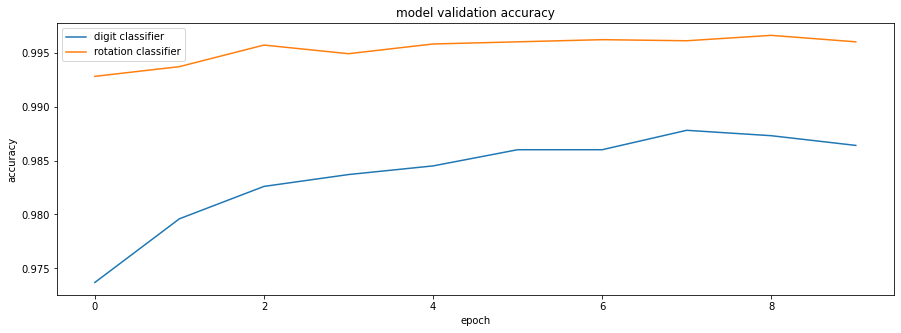

In [49]:
plt.figure(figsize=(15,5))
plt.plot(model_log.history['val_digit_output_accuracy'])
plt.plot(model_log.history['val_rotation_output_accuracy'])
plt.title('model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['digit classifier', 'rotation classifier'], loc='upper left')
plt.show()

Final accuracy score

In [50]:
print('CNN Batch Normalization Digit validation accuracy', round(max(model_log.history['val_digit_output_accuracy']),4), 
        'Rotation validation accuracy', round(max(model_log.history['val_rotation_output_accuracy']),4))

CNN Batch Normalization Digit validation accuracy 0.9878 Rotation validation accuracy 0.9966
